# Machine Learning modelling for Insurance claims prediction

## Intro
### Objective
In this notebook, we aim to build a machine learning model to predict whether an insurance claim will be filed based on policyholder characteristics. We will evaluate different models and select the one that provides the best performance.

### Steps
1. Load the preprocessed data (see notebook 3_Feature_Engineering)
2. Split the data into training and testing sets
3. Train multiple classification models and evaluate them
4. Fine-tune the best-performing model
5. Save the final model for future uses.

# 1. Load Data

In [5]:
# Import libraries
import pandas as pd

# Load the preprocessed datasets
data = pd.read_csv('../data/processed_data.csv')
data.head()

,charges,sex_encoded,smoker_encoded,region_northwest,region_southeast,region_southwest,child_1,child_2,child_3,child_4,child_5,age_scaled,log_bmi_scaled
0,16884.92400,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.438764,-0.370580
1,1725.55230,1,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.509965,0.574704
2,4449.46200,1,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.797954,0.460223
3,21984.47061,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.441948,-1.383560
4,3866.85520,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.513149,-0.200105


# 2. Split Data
Separate features and target and split into training and testing sets

In [7]:
from sklearn.model_selection import train_test_split

# Separate features and target variable
X = data.drop(columns=['charges'])
y = data['charges']

# Split into train / test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (1070, 12)
Testing data shape: (268, 12)


# 3. Model selection
Train multiple models (e.g. RandomForest, XGBoost) and compare their performance

In [28]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.3 MB/s eta 0:00:00


In [9]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize models
rf_model = RandomForestRegressor(random_state=42)
xgb_model = XGBRegressor(
    n_estimators=100,  # number of trees
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# Train models
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate models using regression metrics
print("Random Forest Regression Metrics:")
print(f"MSE: {mean_squared_error(y_test, y_pred_rf)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_rf)}")
print(f"R²: {r2_score(y_test, y_pred_rf)}")

print("\nXGBoost Regression Metrics:")
print(f"MSE: {mean_squared_error(y_test, y_pred_xgb)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_xgb)}")
print(f"R²: {r2_score(y_test, y_pred_xgb)}")

Random Forest Regression Metrics:
MSE: 20778167.325470977
MAE: 2449.9186935109196
R²: 0.8661620798713451

XGBoost Regression Metrics:
MSE: 19297348.78972114
MAE: 2449.7116339037575
R²: 0.8757004414509906


- Mean Squared Error (MSE): Measures average squared difference between predicted and actual values
- Mean Absolute Error (MAE): Measures average absolute difference between predicted and actual values
- R² Score: Indicates how well the model explains the variance in the data

XGBoost Model shows a better performance. 

# 4. Hyperparameter Tuning

In [17]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for XGBoost with wider rangess
param_grid = {
    'n_estimators': [100, 200, 300, 500,1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9]
}

# Grid search for XGBoost
grid_search = GridSearchCV(
    estimator=xgb_model, 
    param_grid=param_grid,
    cv=5, #5-fold cross-validation
    scoring='neg_mean_squared_error',
    n_jobs=-1 # use all available cores
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Access best parameters and results
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters:", best_params)

Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}


# 5. Final model

In [29]:
# Refining the model
final_model = XGBRegressor(
    n_estimators=500,  # number of trees
    learning_rate=0.01,
    max_depth=3,
    random_state=42
)

final_model.fit(X_train, y_train)
y_pred_final = final_model.predict(X_test)
print("Mean Absolute Error: " + str(mean_absolute_error(y_pred_final, y_test)))

Mean Absolute Error: 2493.6467092765274


# 6. Model Evaluation
## 1. Accuracy, Precision, Recal, F1-score

In [45]:
print(type(y_test))
print(type(y_pred_final))

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


In [87]:
from sklearn.metrics import accuracy_score, classification_report

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred_xgb)
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = mean_squared_error(y_test, y_pred_xgb, squared=False)  # RMSE is sqrt of MSE
r2 = r2_score(y_test, y_pred_xgb)

# Print evaluation metrics
print("XGBoost Regression Model Performance:\n")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

XGBoost Regression Model Performance:

Mean Absolute Error (MAE): 2449.71
Mean Squared Error (MSE): 19297348.79
Root Mean Squared Error (RMSE): 4392.87
R² Score: 0.8757


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## ROC-AUC Curv & Score
The ROC-AUC score shows how well the model distinguishes between classes. A higher score (closer to 1) means better performance.

Since ROC-AUC is a classification metric it cannot be used for regression. Instead we use a residual plot and a prediction vs Actual plot to visualise performance.

### Residual Plot
Shows how far predictions are from actual values

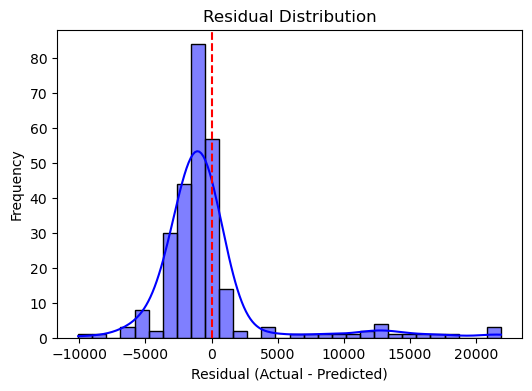

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals
residuals = y_test - y_pred_xgb

# Plot residuals
plt.figure(figsize=(6, 4))
sns.histplot(residuals, bins=30, kde=True, color="blue")
plt.axvline(x=0, color="red", linestyle="--")  # Reference line at 0
plt.title("Residual Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()

**Conclusions from Residual plot:**
- Distribution shape: the residuals follow roughly a normal distribution witha  peak centered closed to zero, which is a positive sign for a regression model.
- Central tendency: Most residuals are clustered around 0 indicating that many preductions are close to the actual values
- Spread: The residulas range approximately from -10000 to +20000, with themajority falling between -5000 and +5000.
- Potential outliers: There appear to be some outliers, particularlyon thepositive side (around 10000, 15000 and 20000) suggesting the model underestimate some values
- Slight positive skew: The distribution shows a slight positive skew with a longer tail on the right side, indicating the model tends to underestimate more than overestimate.
- Heteroscedascity: The plot doesn't show clear patterns of variance changing across the residual range, which is good for regression assumptions

Overall, your model appears reasonably well-behaved but could potentially benefit from adressing the outliers and slight skew to improve prediction accuracy.

### Prediction vs. Actual plot
Shows how close predictions are to actual values

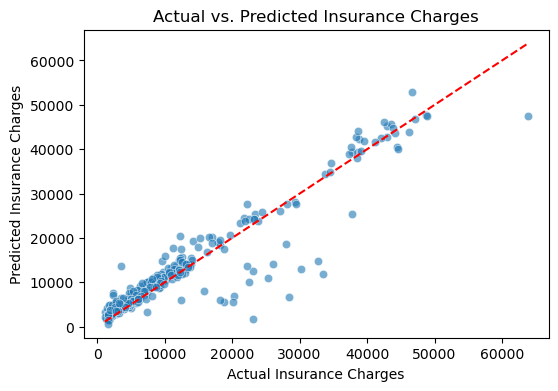

In [96]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")  # Perfect predictions line
plt.xlabel("Actual Insurance Charges")
plt.ylabel("Predicted Insurance Charges")
plt.title("Actual vs. Predicted Insurance Charges")
plt.show()

**Conclusions:**
- Strong correlation: There's a clear positive linear relationship between actual and predicted values, with most points falling close to the diagonal red line, indicating good model performance.

- Range accuracy: The model performs consistently across the entire range of insurance charges (from approximately 0 to 60,000).

- Some prediction errors: Several points deviate from the ideal line, particularly in the:

   - Mid-range (20,000-30,000) where some predictions appear lower than actual values
   - High-range (40,000-60,000) where there's more scatter around the line

- Potential underprediction: More points appear to fall below the diagonal line than above it, suggesting a slight tendency to underpredict insurance charges, especially for higher values.

- Clustering pattern: There's a dense cluster of predictions in the lower range (0-15,000), indicating most insurance charges in your dataset fall within this range.

- Overall fit: The model appears to fit the data well, with no obvious non-linear patterns that would suggest the model is missing important relationships.

This plot confirms what the residual plot suggested - your XGBRegressor model is performing reasonably well but could potentially benefit from improvements to better handle some of the higher-value predictions.

## Feature importance
Understanding which features are most important can provide valuable insights.

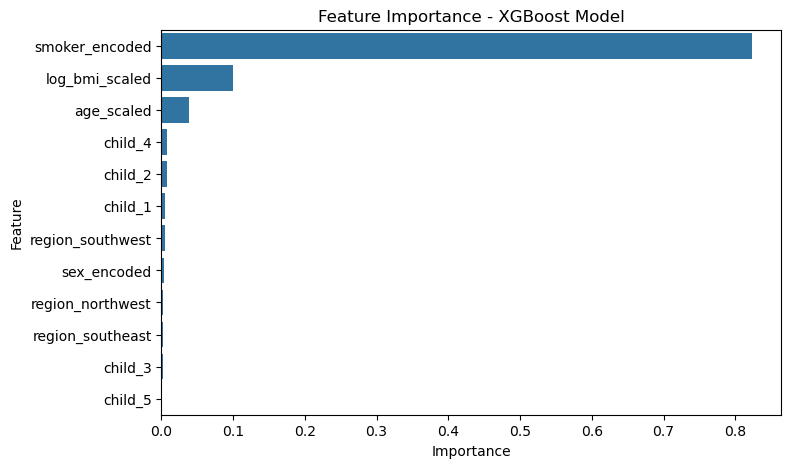

In [85]:
importances = final_model.feature_importances_
feature_names = X_train.columns

# Create a Dataframe for feature importance
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=importance_df)
plt.title("Feature Importance - XGBoost Model")
plt.show()

**Conclusions:**
- Dominant predictor: "smoker_encoded" is by far the most important feature, with an importance score of approximately 0.8 (or 80%), suggesting that smoking status is the primary determinant of insurance charges.

- Secondary factors: "log_bmi_scaled" is the second most important feature, but with significantly lower importance (around 0.15 or 15%), indicating that BMI has a moderate but much smaller impact than smoking status.

- Tertiary factor: "age_scaled" is the third most important feature, with importance around 0.05 (5%), showing that age plays a small but meaningful role in predicting insurance charges.

- Minor contributors: The remaining features (child variables, region variables, and sex_encoded) all have very low importance scores (below 0.05), indicating they contribute minimally to the model's predictions.

- Business implications: This suggests that insurance pricing is heavily influenced by whether a person smokes, with some consideration for their BMI and age, while other demographic factors play relatively minor roles.

- Model focus: The extreme dominance of the smoking variable suggests the model might be primarily distinguishing between two groups (smokers vs. non-smokers) rather than capturing more nuanced relationships across all variables.

- Feature engineering effectiveness: The logarithmic transformation of BMI appears to have been effective since it emerged as the second most important feature.

This information could be valuable for both understanding the insurance pricing structure and for potential customers to understand what factors most heavily influence their insurance costs.

# 7. Conclusion & Next steps
## Overall summary
XGBoost model performs reasonably well in predicting health insurance charges. The residual plot suggests that most predictions are close to actual values, with some underestimation in higher charge ranges. The actual vs. predicted plot confirms strong correlation but highlights slight underprediction for high-cost policies. Feature importance analysis shows that smoking status is by far the most influential predictor, followed by BMI and age, while other demographic factors contribute minimally.

## Next steps for model improvement
1. Address Outliers
- Winsorize or cap extreme values (e.g., top 1% of charges).
- Consider transforming high-value predictions (e.g., log-transforming target variable).

2. Reduce Underprediction for High Values
- Experiment with quantile regression or custom loss functions that penalize underestimation more.
- Use hyperparameter tuning (e.g., adjusting learning rate, tree depth, gamma in XGBoost).

3. Feature Engineering Enhancements
- Investigate interaction terms (e.g., smoker × age, smoker × BMI).
- Explore polynomial or non-linear transformations for age and BMI.

# 8. Applying the model to Pricing
- Assuming we want premium = predicted charges, this is a 100% loss ratio pricing model (insurers break even).
- To adjust for profitability and risk, consider adding:
   - A loading factor (e.g., 110% × predicted charges for a 90% loss ratio).
   - Uncertainty adjustments (e.g., using prediction intervals instead of point estimates).
   - A risk segmentation strategy (adjust pricing based on predicted vs. actual errors in different subgroups).

The goal is to use the predicted insurance charges as the premium in a 100% loss ratio pricing model. However, pricing models in insurance typically adjust for risk factors, profitability, and market competitiveness. Below, I break down how we could structure a more robust pricing model based on the key insights from feature importance analysis.

## 1️⃣ Base Pricing Model: Direct Prediction Approach
The simplest approach is to set the premium equal to the model's predicted charge:

    Premium =  Y(predicted insurance charge from XGBoost)

This ensures that the expected loss ratio is 100%, meaning the insurer would break even (before expenses). However, this approach does not account for risk variations, competitive adjustments, or business goals.## 

## 2️⃣ Adjusting for Key Risk Factors
From your feature importance analysis, three main variables drive insurance costs:
- Smoker status (dominant factor, ~80%)
- BMI (moderate impact, ~15%)
- Age (small but meaningful impact, ~5%)

Since smoking, BMI, and age significantly influence claims, the pricing model should reflect their impact explicitly. Here’s how we cuold incorporate them: 

### 🏥 Smoker vs. Non-Smoker: Separate Pricing Segments
Smokers tend to have much higher claims, so their premiums should be significantly higher.

Instead of using a single model, build separate pricing models or apply smoker-specific multipliers:
    
    Premium_smokers = Y x (1 + smoker surcharge)
    Premium_non_smokers = Y

Where Y is the predicted value.

- The smoker surcharge could be estimated using the XGBoost feature importance or observed claim ratios.
- If the model already captures this difference well, we can verify by analyzing actual vs. predicted charges separately for smokers and non-smokers.

### ⚖️ BMI: Non-Linear Pricing Adjustment
- Higher BMI correlates with higher claims, but the relationship might not be linear.
- We can apply tiered pricing based on BMI categories:
   - Normal (18.5 - 24.9)    --> Base Premium
   - Overweight (25 - 29.9)  --> +10% premium
   - Obese (30 - 34.9)       --> +20% premium
   - Severe obesity (35+)    --> +30% premium
- These multipliers can be learned from the XGBoost feature effects or from historical claims data.

### 👴 Age: Risk-Based Premium Scaling
- Older policyholders tend to have higher claims, but not necessarily linearly.
- A common approach is to apply an age factor:

    Age Factor = 1 + alpha (age - 40)

- The coefficient alpha can be estimated from the model's impact on predicted charges

## 3️⃣ Accounting for Uncertainty: Confidence Intervals for Pricing
Instead of using point predictions, consider prediction intervals (e.g., 95% confidence range):

    Premium - Y + k + theta_y

- k is a safety margin (typically between 1.1 and 1.3 for 90%-95% confidence level)
- theta_y is the standard deviation of residuals (uncertainty prediction)

## 4️⃣ Adding a Loading for Profitability & Expenses
Insurers need to cover expenses, commissions, and profit margins. This is done by applying a loading factor:

    Final Premium = Base Premium x (1 + Expense loading + Profit margin)

- Expense Loading = Covers administrative costs, distribution, underwriting. Typically 10%-30%.
- Profit Margin = Ensures sustainable pricing, typically 5%-15%, depending on competition.

For example, if the base premium is €5000 and we assume a 10% expense loading and 10% profit margin:

    Final premium = 5000 x (1.1 +0.1) = 6000

## 5️⃣ Final Pricing Model Formula
Bringing everything together, the final premium can be structured as:

    Premium = (Y x Risk adjustments) + k x theta_y

    Final Premium = Premium x (1 + Expense loading + Profit margin)

## 6️⃣ Next Steps for Implementation
1. Validate segment-specific predictions
   - Compare actual vs. predicted charges separately for smokers, high BMI groups, and older policyholders.

2. Estimate risk-based multipliers
   - Use XGBoost’s feature contributions to derive optimal adjustments (e.g., how much more should smokers pay?).

3. Test different profit & expense loadings
   - Simulate different expense & profit scenarios to ensure competitive pricing.

4. Explore quantile regression for better tail risk modeling
   - This helps reduce underprediction in high-cost cases.